In [1]:
!pip install pytorch-fid einops

  Using cached pytorch_fid-0.3.0-py3-none-any.whl.metadata (5.3 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.8 MB/s eta 0:00:00
Using cached pytorch_fid-0.3.0-py3-none-any.whl (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.0 MB/s eta 0:00:00

In [2]:
!git clone https://github.com/NVlabs/edm.git

fatal: destination path 'edm' already exists and is not an empty directory.


In [3]:
!wget https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-uncond-vp.pkl

--2024-10-28 09:51:33--  https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-uncond-vp.pkl
Resolving nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)... 108.156.201.85, 108.156.201.109, 108.156.201.55, ...
Connecting to nvlabs-fi-cdn.nvidia.com (nvlabs-fi-cdn.nvidia.com)|108.156.201.85|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223173327 (213M) [binary/octet-stream]
Saving to: ‘edm-cifar10-32x32-uncond-vp.pkl.1’

edm-cifar10-32x32-u 100%[===================>] 212.83M  24.7MB/s    in 9.7s    

2024-10-28 09:51:44 (21.9 MB/s) - ‘edm-cifar10-32x32-uncond-vp.pkl.1’ saved [223173327/223173327]



In [4]:
!git clone https://github.com/LuChengTHU/dpm-solver.git
import sys
sys.path.append('/content/dpm-solver')

fatal: destination path 'dpm-solver' already exists and is not an empty directory.


In [5]:
!pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [6]:
%cd /content/edm
!mamba env update -n base -f environment.yml

/content/edm
pytorch/linux-64                                            Using cache
pytorch/noarch                                              Using cache
nvidia/linux-64                                             Using cache
nvidia/noarch                                               Using cache
conda-forge/linux-64                                        Using cache
conda-forge/noarch                                          Using cache


Looking for: ["python[version='>=3.8,<3.10']", 'pip', "numpy[version='>=1.20']", "click[version='>=8.0']", "pillow[version='>=8.3.1']", "scipy[version='>=1.7.1']", 'pytorch=1.12.1', 'psutil', 'requests', 'tqdm', 'imageio']



  Pinned packages:

  - python 3.10.*
  - python_abi 3.10.* *cp310*
  - cuda-version 12.*


warning  libmamba Added empty dependency for problem type SOLVER_RULE_UPDATE
Could not solve for environment specs
The following package could not be installed
└─ python >=3.8,<3.10  is requested and can be installed.


In [7]:
import torch
import numpy as np
from pytorch_fid import fid_score
from tqdm import tqdm
from einops import rearrange
from PIL import Image
import pickle
import os

In [8]:
def load_edm_model_with_pickle(file_path):
    with open(file_path, 'rb') as f:
        model_data = pickle.load(f)
    return model_data

model_path = "/content/edm-cifar10-32x32-uncond-vp.pkl"
model_data = load_edm_model_with_pickle(model_path)

In [9]:
# Установка и настройка модели
model = model_data['ema']
model.eval()

EDMPrecond(
  (model): SongUNet(
    (map_noise): PositionalEmbedding()
    (map_augment): Linear()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm

In [11]:
%cd ..

/content


In [12]:
model.to('cuda')

EDMPrecond(
  (model): SongUNet(
    (map_noise): PositionalEmbedding()
    (map_augment): Linear()
    (map_layer0): Linear()
    (map_layer1): Linear()
    (enc): ModuleDict(
      (32x32_conv): Conv2d()
      (32x32_block0): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
        (skip): Conv2d()
      )
      (32x32_block1): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block2): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (32x32_block3): UNetBlock(
        (norm0): GroupNorm()
        (conv0): Conv2d()
        (affine): Linear()
        (norm1): GroupNorm()
        (conv1): Conv2d()
      )
      (16x16_down): UNetBlock(
        (norm0): GroupNorm

# Dataset CIFAR-10

In [13]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Загрузка CIFAR-10
def download_and_save_cifar10(save_dir='./data'):

    os.makedirs(save_dir, exist_ok=True)

    # Загрузка CIFAR-10 и применение преобразований
    transform = transforms.Compose([transforms.ToTensor()])
    cifar10 = datasets.CIFAR10(root='./', train=False, download=True, transform=transform)

    # Сохранение изображений CIFAR-10
    for idx, (img, _) in enumerate(cifar10):
        img = transforms.ToPILImage()(img)  # Преобразование тензора обратно в изображение
        img.save(os.path.join(save_dir, f'image_{idx}.png'))

# Вызов функции для загрузки и сохранения CIFAR-10
download_and_save_cifar10()

100%|██████████| 170M/170M [00:03<00:00, 51.4MB/s]


Extracting ./cifar-10-python.tar.gz to ./


In [14]:
import torch
import numpy as np
from pytorch_fid import fid_score
from tqdm import tqdm
from PIL import Image
import pickle
import os
import matplotlib.pyplot as plt

In [18]:
# # Клонирование репозитория StyleGAN2-ADA для доступа к dnnlib
# !git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
# import sys
# sys.path.append('/content/stylegan2-ada-pytorch')  # Укажите путь к dnnlib

# # Теперь можно импортировать dnnlib
# import dnnlib

Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 131 (delta 0), reused 1 (delta 0), pack-reused 128 (from 1)
Receiving objects: 100% (131/131), 1.13 MiB | 57.89 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [15]:
import PIL.Image

# Метод Эйлера 1-го порядка

# Метод Эйлера для генерации изображений

Метод Эйлера — это численный метод для решения обыкновенных дифференциальных уравнений, который используется для генерации изображений на основе диффузионной модели. В данном коде применяется метод Эйлера первого порядка, чтобы постепенно восстанавливать изображение из начального шума.

### Основная идея метода Эйлера

Для численного решения дифференциального уравнения мы можем разложить процесс изменения состояния по времени на маленькие шаги. При каждом шаге метод Эйлера обновляет текущее состояние на основе производной (или "скорости"):

$$
x_{t+\Delta t} = x_t + \Delta t \cdot f(x_t, t)
$$

где:
- $x_t$ — текущее состояние на шаге $t$,
- $\Delta t$ — размер шага,
- $f(x_t, t)$ — производная, которая определяет изменение $x_t$ по времени $t$. d_cur

### Как метод Эйлера применяется в функции `generate_samples_euler`

1. **Инициализация латентных переменных**:
   - Латентные переменные инициализируются нормальным распределением, что соответствует начальному шуму в диффузионной модели.

2. **Настройка уровней шума**:
   - Параметры $\sigma_{\text{min}}$ и $\sigma_{\text{max}}$ определяют диапазон шума, который поддерживает модель, а $\rho$ управляет распределением шагов по времени.

3. **Расчет временных шагов**:
   - Временные шаги $t$ рассчитываются в соответствии с графиком шума, создавая равномерное распределение значений между $\sigma_{\text{min}}$ и $\sigma_{\text{max}}$. Это позволяет контролировать уровень шума на каждом этапе.

4. **Метод Эйлера для восстановления изображения**:
   - Для каждого временного шага $t_{\text{cur}}$:
     - Предсказание изображения на текущем шаге $x_{\text{cur}}$ обновляется с использованием предсказанной "скорости" $d_{\text{cur}}$, которая определяется как $(x_{\text{cur}} - \text{denoised}) / t_{\text{cur}}$, где `denoised` — это предсказанное моделью изображение без шума.
     - После этого $x_{\text{next}}$ обновляется согласно методу Эйлера:
       $$
       x_{\text{next}} = x_{\text{cur}} + (t_{\text{next}} - t_{\text{cur}}) \cdot d_{\text{cur}}
       $$

5. **Приведение изображений в диапазон RGB**:
   - После завершения всех шагов значения пикселей приводятся к диапазону RGB и сохраняются в виде изображений.

6. **Подсчет FID (Fréchet Inception Distance)**:
   - После генерации изображения оцениваются по метрике FID, которая измеряет схожесть между сгенерированными изображениями и реальными изображениями, помогая оценить качество генерации.

Этот процесс позволяет получить изображения, которые постепенно очищаются от шума, пока не восстановится изображение, соответствующее исходному распределению.

In [20]:
# Функция для генерации 10,000 изображений методом Эйлера 1-го порядка
def generate_samples_euler(network, num_steps=10, num_samples=10000, batch_size=200, device='cuda'):
    os.makedirs('./generated_images_euler', exist_ok=True)
    torch.manual_seed(0)  # Для воспроизводимости

    # Основной цикл генерации с учетом батчей
    for batch_start in tqdm(range(0, num_samples, batch_size), desc="Generating images"):
        # Подготовка латентных переменных
        latents = torch.randn([batch_size, network.img_channels, network.img_resolution, network.img_resolution], device=device)

        # Настройка уровней шума, поддерживаемых сетью
        sigma_min, sigma_max, rho = max(0.002, network.sigma_min), min(80, network.sigma_max), 7
        # Создание индексов шагов step_indices
        step_indices = torch.arange(num_steps, dtype=torch.float64, device=device)
        # нелинейное распределение уровней шума t_steps от sigma_max до sigma_min с учетом параметра rho.
        # Это распределение временных шагов контролирует уровень шума на каждом шаге и позволяет более плавно переходить от sigma_max к sigma_min.
        t_steps = (sigma_max ** (1 / rho) + step_indices / (num_steps - 1) * (sigma_min ** (1 / rho) - sigma_max ** (1 / rho))) ** rho
        # Добавление последнего значения t_N = 0
        t_steps = torch.cat([network.round_sigma(t_steps), torch.zeros_like(t_steps[:1])])  # t_N = 0

        # Метод Эйлера 1-го порядка
        # Начальный шаг: инициализация x_next с учетом первого временного шага t_steps[0]
        x_next = latents.to(torch.float64) * t_steps[0]
        # Цикл по временным шагам t_cur и t_next в обратном направлении
        for t_cur, t_next in zip(t_steps[:-1], t_steps[1:]):  # 0, ..., N-1
            x_cur = x_next
            # Предсказание "очищенного" изображения denoised
            denoised = network(x_cur, t_cur).to(torch.float64)
            # Расчет изменения d_cur для метода Эйлера
            # используется для определения того, насколько "быстро" должно происходить очищение изображения на этом шаге.
            d_cur = (x_cur - denoised) / t_cur
            # x_next обновляется с учетом текущего значения x_cur и изменения d_cur, умноженного на временной интервал (t_next - t_cur)
            # Таким образом, x_next на следующем временном шаге приближается к "очищенной" версии изображения, уменьшая уровень шума.
            x_next = x_cur + (t_next - t_cur) * d_cur

        # Приведение изображений в диапазон RGB
        image_batch = (x_next * 127.5 + 128).clip(0, 255).to(torch.uint8)

        # Сохранение изображений
        for i, img in enumerate(image_batch):
            idx = batch_start + i
            img = np.transpose(img.cpu().numpy(), (1, 2, 0))  # Переключение осей для PIL (H, W, C)
            Image.fromarray(img).save(f'./generated_images_euler/sample_{idx}.png')

    # Отображение первых 16 изображений
    display_generated_images('./generated_images_euler')

# Функция для отображения первых 16 изображений
def display_generated_images(directory):
    images = sorted([os.path.join(directory, fname) for fname in os.listdir(directory)[:16]])
    plt.figure(figsize=(10, 10))
    for i, img_path in enumerate(images):
        plt.subplot(4, 4, i + 1)
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Подсчет FID для сгенерированных изображений
def calculate_fid_for_generated_images(gen_dir, real_data_dir='./data'):
    fid = fid_score.calculate_fid_given_paths([gen_dir, real_data_dir], batch_size=64, device='cuda', dims=2048)
    print(f"FID Score: {fid}")

Generating images: 100%|██████████| 50/50 [01:22<00:00,  1.65s/it]


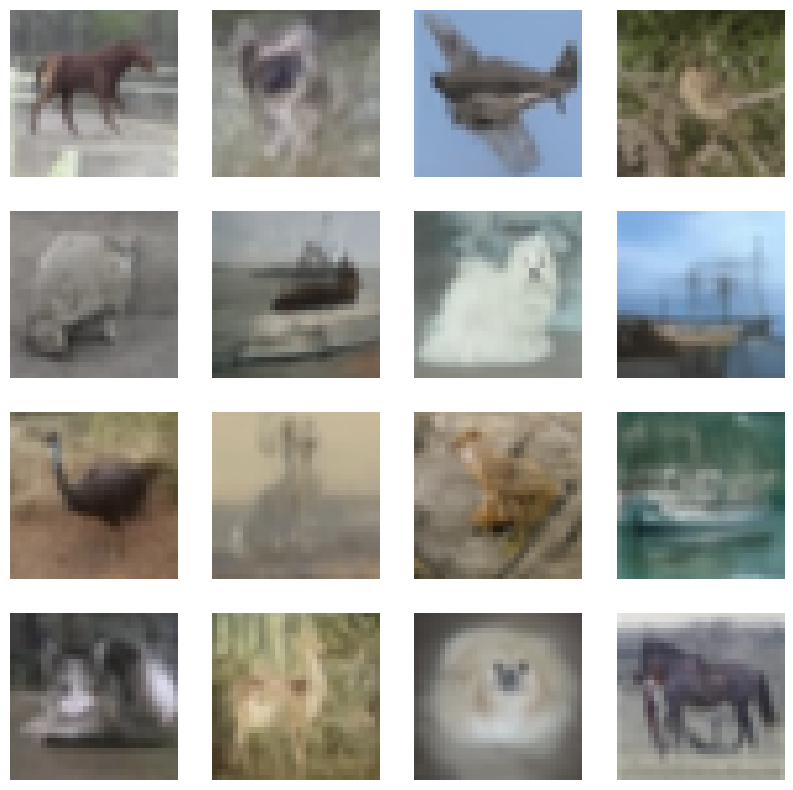

100%|██████████| 157/157 [00:04<00:00, 31.58it/s]


FID Score: 22.92834466381504


Generating images: 100%|██████████| 50/50 [02:39<00:00,  3.19s/it]


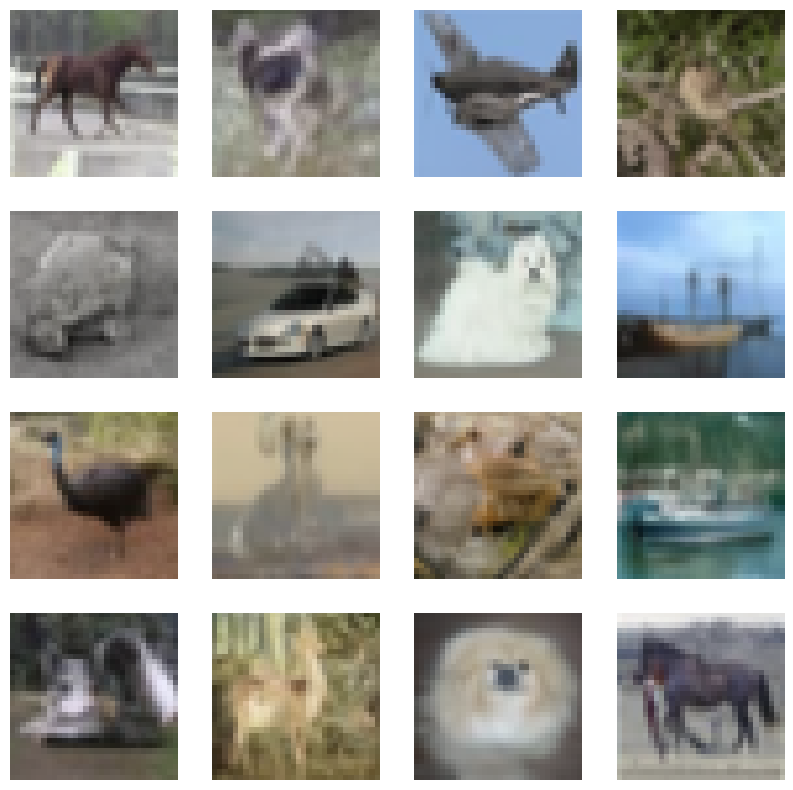

100%|██████████| 157/157 [00:04<00:00, 31.48it/s]


FID Score: 10.668254286416698


In [21]:
for steps in [10, 20]: # для 10000
    generate_samples_euler(model, num_steps=steps)
    calculate_fid_for_generated_images('./generated_images_euler')

Повышение количества шагов (от 10 до 20) уменьшает FID-скор, что свидетельствует о том, что больший шаг улучшает качество изображений, так как больше шагов позволяет моделировать процесс генерации более плавно и стабильно.

# DPM Solver++

## Класс NoiseScheduleVP

### Описание
Класс `NoiseScheduleVP` управляет графиком шума для прямого процесса в диффузионной модели, используя стохастическое дифференциальное уравнение (SDE) типа VP (Variational Process). Основная цель класса — регулировать добавление шума на каждом шаге.

Для конкретного времени $t$, у нас есть выражения:

1. **Коэффициент ослабления**: $\log \alpha_t$  
   $$\log \alpha_t = \text{marginal\_log\_mean\_coeff}(t)$$

2. **Стандартное отклонение**: $\sigma_t$
   $$\sigma_t = \text{marginal\_std}(t)$$

3. **Полулогарифм отношения сигнал-шум (SNR)**: $\lambda_t$  
   Определяется как:
   $$\lambda_t = \log \alpha_t - \log \sigma_t$$

Эти функции помогают преобразовывать параметры между временем, логарифмом коэффициента и стандартным отклонением, что важно для работы с диффузионными моделями.

### Параметры
- **schedule**: Определяет тип графика шума. Значение `'discrete'` используется для дискретного времени, `'linear'` и `'cosine'` — для графиков шума непрерывного времени.
- **betas** и **alphas_cumprod**: Параметры дискретного времени, определяющие скорость, с которой изображение переходит от чистого к зашумленному.
- **continuous_beta_0** и **continuous_beta_1**: Начальные и конечные параметры бета для линейного графика шума в непрерывном времени.

---
## Класс model_wrapper

### Описание
`model_wrapper` — это обертка, которая принимает на вход модель предсказания шума (`model`) и график шума, а также управляет параметрами для разных типов диффузионных моделей. Обертка нужна для согласования модели с шумом во времени.

### Параметры
- **model_type**: Тип предсказания:
  - `"noise"`: модель предсказывает добавленный шум.
  - `"x_start"`: предсказание начального изображения без шума.
  - `"v"`: предсказание скорости, являющейся производной изображения по времени.
  - `"score"`: предсказание оценки, связанной с функцией правдоподобия данных.

Эта обертка создает функцию `model_fn`, которая принимает в качестве входа данные и непрерывное время, что нужно для корректной работы `DPM-Solver`.

---
## Класс DPM_Solver

### Описание
Класс `DPM_Solver` решает обратные ОДУ (обыкновенные дифференциальные уравнения), чтобы восстановить изображение из зашумленного состояния. Он поддерживает как `DPM-Solver`, так и `DPM-Solver++`, которые отличаются порядком точности.

### Формулы и метод Эйлера

Метод Эйлера первого порядка используется для решения уравнения:

$$
x_{t+\Delta t} = x_t + \Delta t \cdot f(x_t, t)
$$

Здесь $f(x_t, t)$ — это функция скорости, определяющая, насколько быстро изменяется состояние $x_t$ по отношению к времени $t$.

В `DPM-Solver++`, добавлены корректировки, такие как **динамическое пороговое значение** (dynamic thresholding), предложенное в работе *Imagen*. Оно улучшает качество генерации, контролируя диапазон значений пикселей:

$$
x_0 = \min(\max(x_0, -\text{thresholding\_max\_val}), \text{thresholding\_max\_val})
$$

### Параметры класса DPM_Solver
- **model_fn**: Функция предсказания шума, принимающая непрерывное время и возвращающая предсказание шума.
- **algorithm_type**: Указывает, использовать ли `dpmsolver` или `dpmsolver++`.
- **correcting_x0_fn**: Функция корректировки для значений $x_0$, например, `"dynamic_thresholding"`, чтобы улучшить качество генерации.
  
Эти настройки помогают `DPM_Solver` корректно обрабатывать модель, настраивая параметры для стабильной генерации изображений.

---

### Общий процесс
1. `NoiseScheduleVP` определяет график шума и параметризацию.
2. `model_wrapper` подготавливает модель для работы с шумом и временем.
3. `DPM_Solver` решает уравнения для генерации изображений, начиная с зашумленного состояния и переходя к исходному изображению.


In [16]:
%cd /content/edm
from dpm_solver_pytorch import NoiseScheduleVP, model_wrapper, DPM_Solver
%cd ..

/content/edm
/content


In [17]:
noise_schedule = NoiseScheduleVP(schedule='discrete', alphas_cumprod=torch.linspace(0.1, 0.9, 1000))

In [18]:
model_fn = model_wrapper(
    model=model,
    noise_schedule=noise_schedule,
    model_type="noise",
)

In [19]:
# Функция для генерации изображений с использованием DPM-Solver++
def generate_samples_dpm_solver(model_fn, noise_schedule, solver_order, num_steps, num_samples=10000):
    solver = DPM_Solver(model_fn=model_fn, noise_schedule=noise_schedule, algorithm_type="dpmsolver++")
    images = []
    batch_size = 200

    # Генерация изображений
    for _ in tqdm(range(num_samples // batch_size), desc=f"Generating (Order {solver_order}, Steps {num_steps})"):
        with torch.no_grad():
            noise = torch.randn((batch_size, 3, 32, 32), device="cuda")
            generated_images = solver.sample(noise, steps=num_steps, order=solver_order).clamp(0, 1) * 255
            images.extend(generated_images.cpu().numpy().astype(np.uint8))

    # Сохранение изображений
    gen_dir = f'/content/generated_images_order_{solver_order}_steps_{num_steps}'
    os.makedirs(gen_dir, exist_ok=True)
    for idx, img in enumerate(images):
        img = np.transpose(img, (1, 2, 0))  # (H, W, C) для PIL
        Image.fromarray(img).save(os.path.join(gen_dir, f'sample_{idx}.png'))

    # Отображение первых 16 изображений
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        img = np.transpose(images[i], (1, 2, 0))  # для matplotlib
        plt.imshow(img)
        plt.axis('off')
    plt.show()

    return gen_dir

Generating (Order 1, Steps 10): 100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


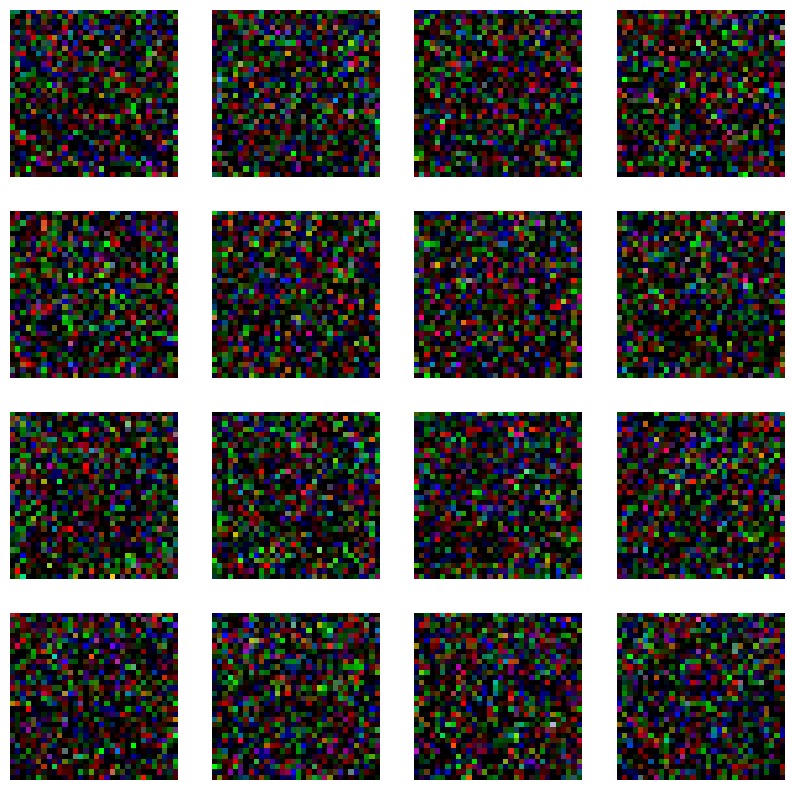

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 277MB/s]
100%|██████████| 157/157 [00:04<00:00, 31.67it/s]


DPM-Solver++ Order 1, Steps 10: FID = 388.1055989398866


Generating (Order 1, Steps 20): 100%|██████████| 50/50 [02:41<00:00,  3.24s/it]


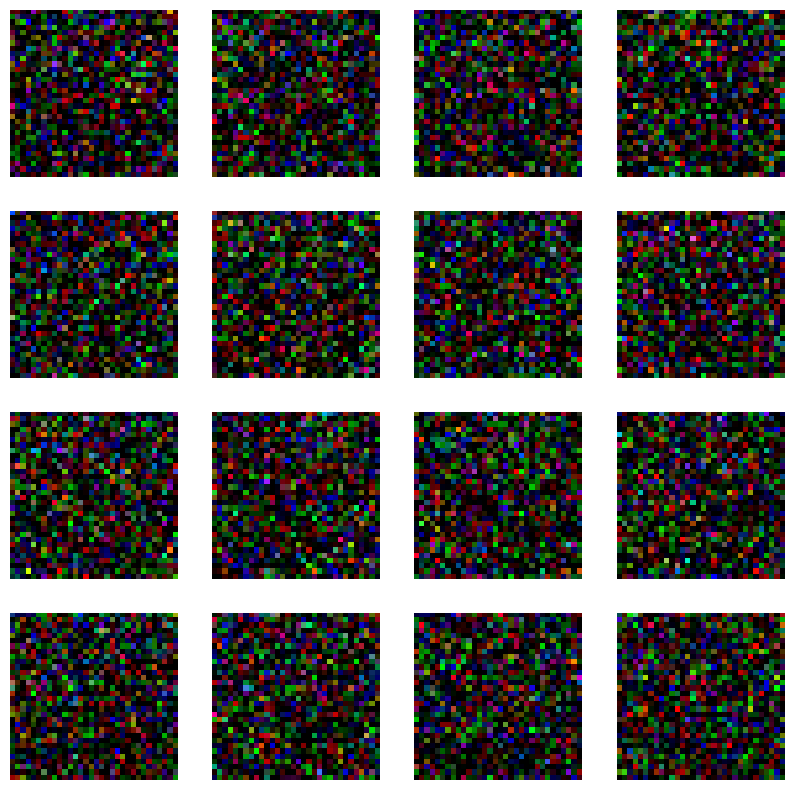

100%|██████████| 157/157 [00:05<00:00, 31.35it/s]


DPM-Solver++ Order 1, Steps 20: FID = 388.21213567715813


Generating (Order 2, Steps 10): 100%|██████████| 50/50 [01:21<00:00,  1.63s/it]


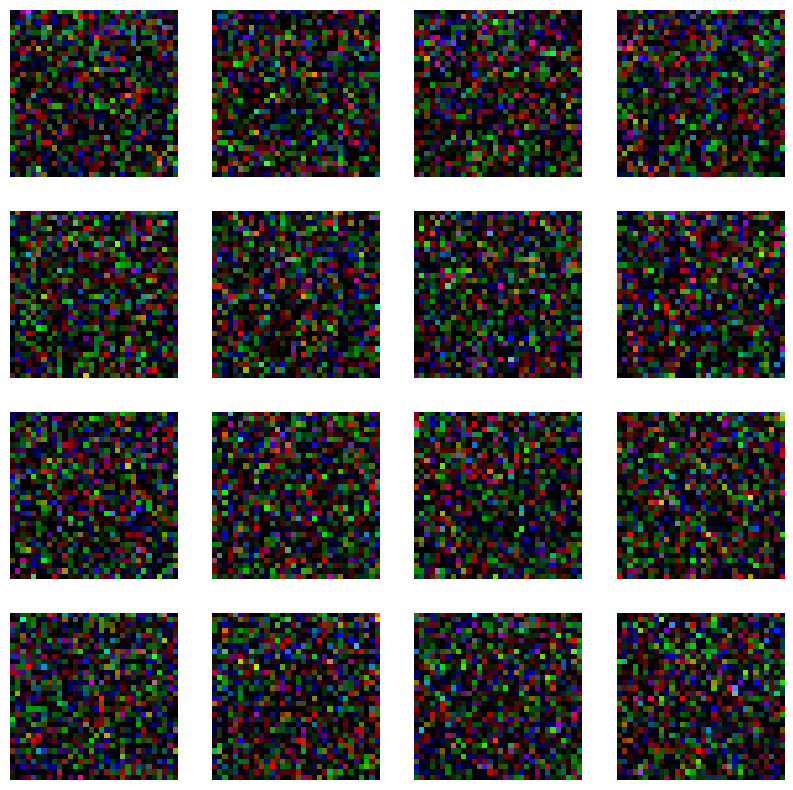

100%|██████████| 157/157 [00:04<00:00, 31.45it/s]


DPM-Solver++ Order 2, Steps 10: FID = 387.8969427587541


Generating (Order 2, Steps 20): 100%|██████████| 50/50 [02:42<00:00,  3.26s/it]


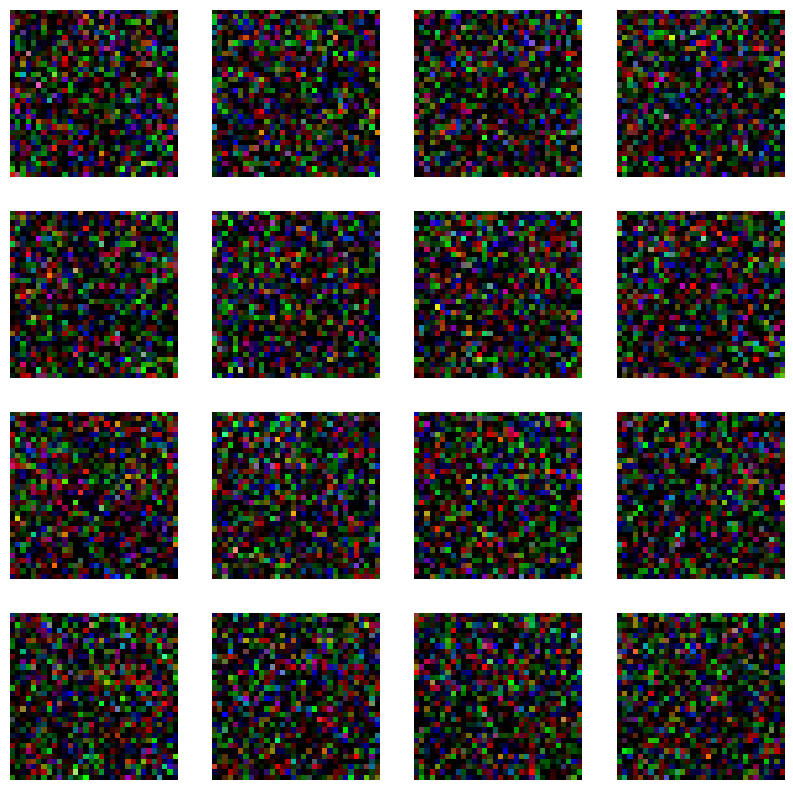

100%|██████████| 157/157 [00:04<00:00, 31.61it/s]


DPM-Solver++ Order 2, Steps 20: FID = 388.05656414694465


Generating (Order 3, Steps 10): 100%|██████████| 50/50 [01:21<00:00,  1.64s/it]


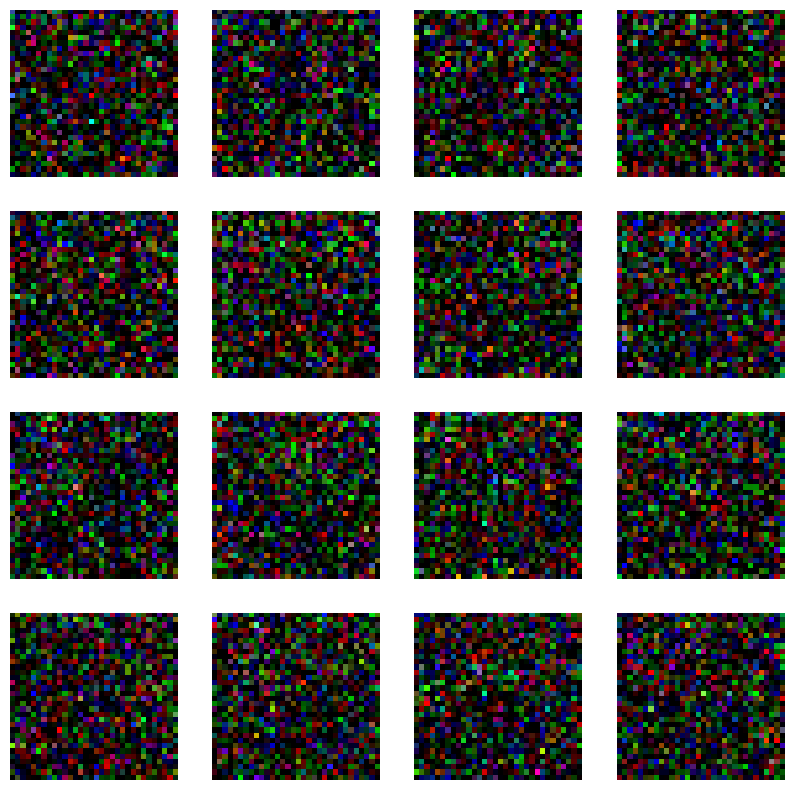

100%|██████████| 157/157 [00:04<00:00, 31.45it/s]


DPM-Solver++ Order 3, Steps 10: FID = 387.7515072528399


Generating (Order 3, Steps 20): 100%|██████████| 50/50 [02:43<00:00,  3.27s/it]


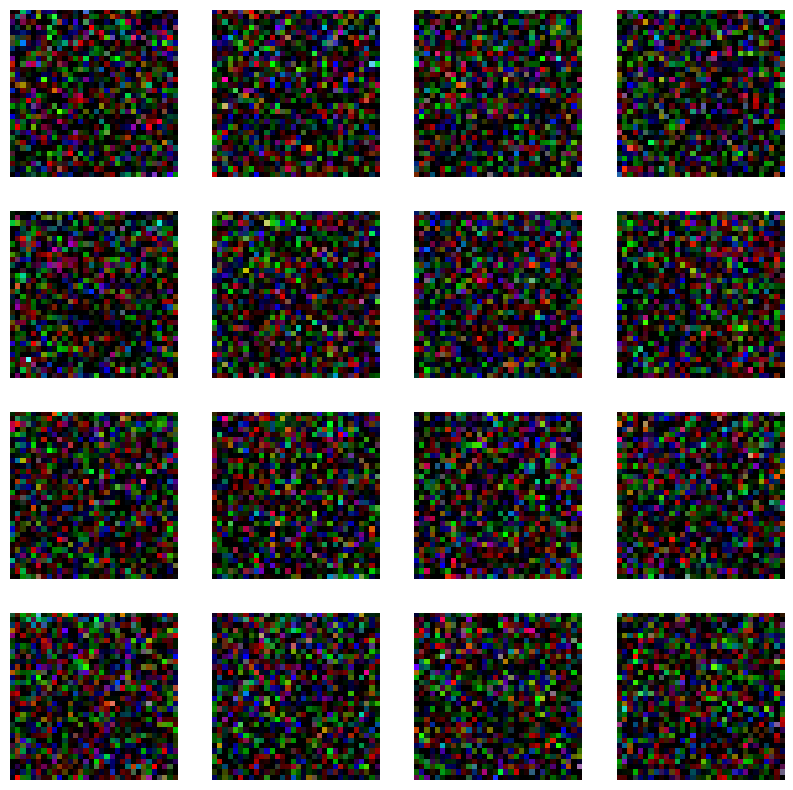

100%|██████████| 157/157 [00:05<00:00, 31.37it/s]


DPM-Solver++ Order 3, Steps 20: FID = 388.0433350515276


In [20]:
for order in [1, 2, 3]:
    for steps in [10, 20]:
        gen_dir = generate_samples_dpm_solver(model_fn, noise_schedule, solver_order=order, num_steps=steps)
        fid = fid_score.calculate_fid_given_paths([gen_dir, './data'], batch_size=64, device='cuda', dims=2048)
        print(f"DPM-Solver++ Order {order}, Steps {steps}: FID = {fid}")

Все результаты генерации представляют собой чистый шум, и FID-скоры чрезвычайно высокие (в районе 387–388). Это указывает на то, что модель не может эффективно генерировать осмысленные изображения, и вместо этого просто создает случайные шумовые паттерны.

# Возможные причины появления шума при использовании DPM-Solver++

1. **Некорректная конфигурация noise\_schedule**  
   Параметры графика шума (`noise_schedule`) должны быть тщательно согласованы с параметрами модели и уровнем шума в тренировочных данных. Если график шума настроен неправильно, это может привести к тому, что генерация не стабилизируется и создает шум.  
   - Возможно, настройки `schedule='discrete'` и `alphas_cumprod` требуют других значений или более высокой дискретизации.

2. **Неправильный порядок или шаги в DPM-Solver++**  
   Хотя вы используете разные порядки (1, 2 и 3) и шаги (10 и 20), возможно, конкретные параметры для DPM-Solver++ не оптимальны для данной модели. Например, выбор слишком низкого или слишком высокого порядка может вызвать нестабильность.

3. **Несовместимость архитектуры модели и DPM-Solver++**  
   Возможно, структура модели не адаптирована для работы с DPM-Solver++, так как она может быть обучена на других параметрах шума или графике. Например, в DPM-Solver++ могут требоваться специфические архитектуры, такие как определенные виды слоев или функции активации, которые лучше работают с алгоритмом диффузии.

4. **Ошибка в реализации обертки model\_wrapper**  
   Возможно, обертка `model_wrapper` настроена неверно. Если параметры модели, такие как `model_type`, переданы неправильно, это может привести к неправильной обработке шума и, как следствие, к генерации случайного шума.

5. **Недостаточно шагов для стабилизации генерации**  
   Поскольку шагов у вас всего 10 и 20, это может быть недостаточно для более сложного алгоритма, как DPM-Solver++. Возможно, для данной модели требуется больше шагов (например, 50 или 100) для устойчивой генерации изображений.

6. **Ошибки в масштабировании и преобразовании изображений**  
   Возможны ошибки в конечном преобразовании или масштабировании значений, из-за чего изображения кажутся полностью шумовыми. Например, если диапазон значений изображения не преобразуется должным образом (например, не масштабируется от 0 до 255), то это может привести к неправильному отображению.

7. **Неоптимальные гиперпараметры модели**  
   Возможно, стоит проверить параметры обучения модели, такие как `sigma_min`, `sigma_max`, или настройки EMA (экспоненциального среднего), так как они могут влиять на стабильность и качество генерации.

---

# Вопросы для преподавателя

1. **Параметры графика шума (Noise Schedule)**  
   - Как лучше настроить график шума (`noise_schedule`) для модели, использующей DPM-Solver++? Должен ли он быть дискретным или можно использовать другие стратегии?
   - Какие значения для `alphas_cumprod` могут быть рекомендованы для CIFAR-10?

2. **Оптимальное количество шагов и порядок**  
   - Какое количество шагов и порядок лучше всего подходят для DPM-Solver++?

3. **Совместимость DPM-Solver++ с конкретной архитектурой**  
   - Может ли быть, что структура моей модели несовместима с DPM-Solver++? Если да, то как можно адаптировать модель для работы с данным алгоритмом?

4. **Применение различных типов шумовых графиков**  
   - Можно ли использовать continuous вместо discrete для графика шума? Если да, как это влияет на качество генерации?

5. **Проверка обертки модели (model\_wrapper)**  
   - Правильно ли я настроил обертку `model_wrapper`? Как можно проверить, что модель действительно обрабатывает шум корректно?

6. **Рекомендации по улучшению FID для DPM-Solver++**  
   - Какие есть общие рекомендации по снижению FID, если метод генерирует только шум? Как изменить параметры генерации или обучения, чтобы улучшить FID?

7. **Требования к архитектуре модели для совместимости с DPM-Solver++**  
   - Есть ли какие-то особые требования к архитектуре модели, чтобы она работала стабильно с DPM-Solver++?

8. **Отображение и масштабирование сгенерированных изображений**  
   - Как убедиться, что сгенерированные изображения корректно отображаются? Есть ли методы для диагностики ошибок, связанных с масштабированием?